# AA1 lab 06

# Dealing with class imbalance

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.datasets import load_breast_cancer, make_classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier

from collections import Counter

pd.set_option('display.precision', 3)
np.random.seed(123) # for reproducibility

It is very common that datasets for classification present an imbalance in the proportion of classes. This is very common for example
with health data where there may be an undesirable, uncommon outcome which is the one we need to detect.

In these cases it is often the case that the different types of errors that a predictor may make are not equal in the sense of their consequence in cost.
As an example, consider a fraud detection system (binary classification task) that classifies transactions (credit card purchases for example) as 
being fraudulent (positive class) or not (negative class). In this case, it is very likely that the system will see few cases of fraud and many many cases of 
non-fraudulent transactions.

Suppose that only 1% of transactions are fraudulent. It is trivial to get a classifier with 99% accuracy: just predict __always negative__. But such a classifier
is __useless__ since typically we would be very interested in identifying the _positive_ (fraudulent) cases correctly! 

It makes sense to look at the confusion matrix where we can see the counts for the different types of errors:

|              | Predicted Negative | Predicted Positive |
|--------------|--------------------|--------------------|
| Actual Negative | True Negative (TN) | False Positive (FP) |
| Actual Positive | False Negative (FN) | True Positive (TP) |

In our case of fraud detection, we would have:

|              | Predicted Negative | Predicted Positive |
|--------------|--------------------|--------------------|
| Actual Negative | 99 | 0 |
| Actual Positive | 1 | 0 |

$$accuracy = \frac{99}{99+1+0+0} = 99\%$$


So, the important message here is the following

> __DO NOT use accuracy for a classification problem where there is class imbalance__.


## Metrics for classification performance


### - Accuracy:

$$accuracy = \frac{\sum_c tp_c}{n}$$

Where $tp_c$ are the true positive predictions for all the classes and n are the total number of samples. This metric is **sensitive to imbalanced data**.

### - Precision (of a class):

$$precision_c = \frac{tp}{tp + fp}$$

Where $tp$ are the true positives (samples correctly predicted of this class) and $fp$ are the false positives (samples from another class predicted incorrectly as this class). This metric measures how much the model is predicting correctly a class with respect all the predictions of this class. We will use this metric when having false positive predictions is very harmful in our model context. 


### - Recall (of a class):

$$recall_c = \frac{tp}{tp + fn}$$

Where $tp$ are the true positives (samples correctly predicted of this class) and fn are the false negatives (samples from this class predicted incorrectly as a different class). This metric measures how much the model is predicting correctly a class with respect all the real values of this class. We will use this metric when having false negative predictions is very harmful in our model context.

### - F1-score (of a class):

$$\frac{2 * precission_c * recall_c }{precission_c + recall_c}$$

The **harmonic mean** of precision and recall. We will use this metric when we want a good balance between precision and recall.  


### - Macro averages:

For __binary__ classification problems, it is customary to report metrics for the positive class only.
In the case of multi-class classification, if all classes are equally important, then we can report __macro__ averages of the relevant metrics (i.e., average accross all classes). If the correct prediction of a particular class is more important, then we may focus the metrics for that specific class.

---

All of these metrics can be computed from the confusion matrix. As an example, we have:

In [8]:
y_true = [0, 1, 2, 2, 2]
y_pred = [0, 0, 2, 2, 1]
target_names = ['class 0', 'class 1', 'class 2']

cm = confusion_matrix(y_true, y_pred)
print('confusion matrix:')
print(pd.DataFrame(data=cm, columns=[f'predicted {c}' for c in target_names], index=[f'true {c}' for c in target_names]))
print()
print(classification_report(y_true, y_pred, target_names=target_names))


confusion matrix:
              predicted class 0  predicted class 1  predicted class 2
true class 0                  1                  0                  0
true class 1                  1                  0                  0
true class 2                  0                  1                  2

              precision    recall  f1-score   support

     class 0       0.50      1.00      0.67         1
     class 1       0.00      0.00      0.00         1
     class 2       1.00      0.67      0.80         3

    accuracy                           0.60         5
   macro avg       0.50      0.56      0.49         5
weighted avg       0.70      0.60      0.61         5



# Probabilistic classifiers: ROC curve and AUC

Receiver Operating Characteristic (ROC) curve and Area Under the Curve (AUC) are commonly used evaluation metrics in binary classification tasks in machine learning.

**ROC Curve:**
The ROC curve is a graphical representation that illustrates the performance of a binary classification model __across different threshold settings__. 
It plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold values.

- **True Positive Rate (TPR)**, also known as sensitivity or recall, measures the proportion of actual positive cases that are correctly identified by the model. It is calculated as TP / (TP + FN).
- **False Positive Rate (FPR)** measures the proportion of actual negative cases that are incorrectly classified as positive by the model. It is calculated as FP / (FP + TN).

The ROC curve demonstrates the trade-off between sensitivity and specificity across different threshold values. A model with a better performance will have an ROC curve that is closer to the top-left corner of the plot, indicating higher TPR and lower FPR across various threshold settings.

**Area Under the Curve (AUC):**
The AUC is a scalar value that quantifies the overall performance of a binary classification model based on its ROC curve. It represents the area under the ROC curve.

- AUC ranges from 0 to 1, where:
  - AUC = 1 indicates a perfect classifier that achieves a TPR of 1 and an FPR of 0 across all threshold values, resulting in a curve that reaches the top-left corner of the plot.
  - AUC = 0.5 indicates a classifier with no discriminatory power, equivalent to random guessing.
  - AUC < 0.5 indicates a classifier that performs worse than random guessing.

A higher AUC value suggests better discrimination ability of the model, indicating that it can distinguish between positive and negative cases more effectively across various threshold settings.

In summary, ROC curve and AUC provide insights into the performance of binary classification models by visualizing the trade-off between sensitivity and specificity and quantifying the model's ability to discriminate between positive and negative cases.

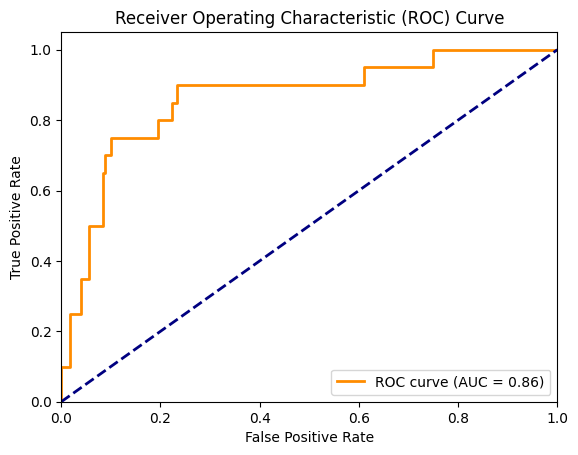

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

# Generate synthetic dataset
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, weights=[0.9, 0.1], random_state=42)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a logistic regression model
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Predict probabilities on the test set
probs = clf.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# Learning in the context of class imbalance

So, what do we do if our data is not balanced?

Well, as a starter we should definitely avoid using __accuracy__ as our performance metric.
In cross-validation, for example, we should focus on those metrics that are relevant to our problem.

Apart from that, there is the issue of model training, where we can proceed in several ways:

- __resampling__: either down-sample majority class or up-sample minority class to make sure all classess are represented and can be learned from
- __cost-sensitive learning__: using algorithms (or adapt existing ones) to avoid specific types of undesirable errors in our application through the introduction of cost matrices


Let us look at an example with the [breast cancer Wisconsin data](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic).

In [10]:
bc = load_breast_cancer()
df = pd.DataFrame(data=bc.data, columns=bc.feature_names)
df['target'] = pd.Series([bc.target_names[y] for y in bc.target], dtype="category")
df.head()


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.118,0.278,0.300,0.147,0.242,0.079,...,17.33,184.60,2019.0,0.162,0.666,0.712,0.265,0.460,0.119,malignant
1,20.57,17.77,132.90,1326.0,0.085,0.079,0.087,0.070,0.181,0.057,...,23.41,158.80,1956.0,0.124,0.187,0.242,0.186,0.275,0.089,malignant
2,19.69,21.25,130.00,1203.0,0.110,0.160,0.197,0.128,0.207,0.060,...,25.53,152.50,1709.0,0.144,0.424,0.450,0.243,0.361,0.088,malignant
3,11.42,20.38,77.58,386.1,0.142,0.284,0.241,0.105,0.260,0.097,...,26.50,98.87,567.7,0.210,0.866,0.687,0.258,0.664,0.173,malignant
4,20.29,14.34,135.10,1297.0,0.100,0.133,0.198,0.104,0.181,0.059,...,16.67,152.20,1575.0,0.137,0.205,0.400,0.163,0.236,0.077,malignant


In [11]:
# Load the Wisconsin Breast Cancer dataset
X, y = bc.data, bc.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Count class occurrences
unique, counts = np.unique(y_train, return_counts=True)
print("Class distribution in the training set:", dict(zip(unique, counts)))

# Calculate class weights to handle imbalance
class_counts = dict(zip(unique, counts))
total_samples = sum(class_counts.values())
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}

# Cross-validate a Random Forest classifier with class weights with n trees
res = {}
for n in np.geomspace(1, 256, num=9, dtype=int):
    clf = RandomForestClassifier(class_weight=class_weights, random_state=42, n_estimators=n)
    res[n] = np.mean(cross_val_score(clf, X_train, y_train, cv=5, scoring='f1_macro'))

# show results of cross-val
print(Counter(res).most_common())

# select best n 
best_n = Counter(res).most_common()[0][0]
print(f'winning hyper-param is n_estimators={best_n}')

# re-fit on training data
clf = RandomForestClassifier(class_weight=class_weights, random_state=42, n_estimators=best_n)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# confusion matrix on test
print("\nConfusion matrix on test set:")
print(confusion_matrix(y_test, y_pred))

# Print classification report
print("\nClassification Report on test set:")
print(classification_report(y_test, y_pred))


Class distribution in the training set: {0: 169, 1: 286}
[(32, 0.9548649731827019), (256, 0.954780134122483), (127, 0.9547176636825718), (63, 0.9498041827697701), (16, 0.9452934779180948), (7, 0.9330182168876646), (4, 0.9321604176964892), (2, 0.9078819687888451), (1, 0.9052997819994827)]
winning hyper-param is n_estimators=32

Confusion matrix on test set:
[[41  2]
 [ 1 70]]

Classification Report on test set:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        43
           1       0.97      0.99      0.98        71

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



## Sampling approaches to deal with imbalance

1. **Random Undersampling**: Randomly remove samples from the majority class to balance the class distribution. This approach can be effective when there is a large amount of data.

2. **Random Oversampling**: Randomly duplicate samples from the minority class to balance the class distribution. This can be effective but may lead to overfitting.

3. **SMOTE (Synthetic Minority Over-sampling Technique)**: Generate synthetic samples for the minority class by interpolating between existing minority class samples. This helps in balancing the class distribution without simply duplicating existing samples.

4. **ADASYN (Adaptive Synthetic Sampling)**: Similar to SMOTE, but it focuses on generating samples near the decision boundary, which can help to tackle the problem of overlapping classes.

5. **Borderline-SMOTE**: A variation of SMOTE that focuses on generating synthetic samples near the border between the minority and majority classes.

6. **NearMiss**: Undersampling technique that selects samples from the majority class that are closest to the minority class samples. This helps to retain information from the majority class while reducing its dominance.

7. **Tomek Links**: Undersampling technique that removes samples from the majority class that are Tomek links with samples from the minority class. Tomek links are pairs of samples from different classes that are closest to each other.

8. **Cluster-Based Over Sampling**: Identify clusters in the minority class and generate synthetic samples within these clusters to balance the class distribution.

9. **Weighted Sampling**: Assign higher weights to samples from the minority class during training to make them more influential in the learning process. This can be implemented through class weights in the loss function.

10. **Ensemble Methods**: Train multiple classifiers on different subsets of the imbalanced dataset and combine their predictions. This can be done using techniques like bagging, boosting, or stacking.

11. **Cost-Sensitive Learning**: Modify the learning algorithm to take into account the misclassification costs associated with different classes. This approach assigns higher penalties to misclassifications of the minority class.

These sampling approaches can be used alone or in combination to address class imbalance in classification tasks, depending on the specific characteristics of the dataset and the problem at hand.

Next, we can find an example that uses SMOTE to up-sample the minority class and then learn with logistic regression

In [12]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import RobustScaler

# Load the Wisconsin Breast Cancer dataset
X, y = bc.data, bc.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scale data as we are going to use logreg
transformer = RobustScaler().fit(X_train)
X_train_scaled = transformer.transform(X_train)
X_test_scaled = transformer.transform(X_test)

# Count class occurrences
unique, counts = np.unique(y_train, return_counts=True)
print("Class distribution in the training set before SMOTE:", dict(zip(unique, counts)))

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Count class occurrences after SMOTE
unique_resampled, counts_resampled = np.unique(y_train_resampled, return_counts=True)
print("Class distribution in the training set after SMOTE:", dict(zip(unique_resampled, counts_resampled)))

# Train a Random Forest classifier after SMOTE
clf = LogisticRegression()
clf.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred = clf.predict(X_test_scaled)

# confusion matrix on test
print("\nConfusion matrix on test set:")
print(confusion_matrix(y_test, y_pred))

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Class distribution in the training set before SMOTE: {0: 169, 1: 286}
Class distribution in the training set after SMOTE: {0: 286, 1: 286}

Confusion matrix on test set:
[[42  1]
 [ 1 70]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        43
           1       0.99      0.99      0.99        71

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



## suggested exercise

- try other up or downsampling technique on same data with some other model, perhaps with hyper-params to cross-validate